<div style="text-align:center;color:Blue">
    <h2> Graph Regression with Graph Neural Networks</h2>
</div>

#### This notebook presents a thorough approach on how to apply Graph Neural Networks (GNNs) to solve a graph regression problem.

We apply graph regression to assign one y-value to an entire graph (in contrast to nodes).
1. We start with a dataset of graphs, based on some structural graph properties - in today's case based on lipophilicity.
2. Accordingly, entire graphs are embedded in such a way that helps us predict a molecular property prediction (a single
lipophilicity value) for each. One can use these embeddings further to do more analysis, such as
to classify them based on a value, such as a lipophilicity range.

Play with the model settings, data splitting, training setups etc. to get the best results from this code and any other data/model you implement based on the information provided.

#### The data: Experimental results of octanol/water distribution coefficient (logD at pH 7.4).
Lipophilicity is an important feature of drug molecules that affects both membrane permeability
and solubility - thus a molecule's interactivity with other molecules.

1.	Import lipophilicity data for 4000 molecules (https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv, or use Python)
2. from PyTorch Geometric’s dataset library (https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)
   
This Lipophilicity dataset is curated from ChEMBL database, provides experimental results of
octanol/water distribution coefficient (logD at pH 7.4) of 4200 compounds.
Read more: https://arxiv.org/pdf/1703.00564.pdf

In [1]:
!pip install dataframe_image
!pip install pubchempy
!pip install rdkit
!pip install torch-geometric

import dataframe_image as dfi
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pubchempy
import rdkit
import torch
import torch.nn.functional as F
import time

from pandas.plotting import table
from rdkit.Chem import Draw
from rdkit import Chem
from sklearn.metrics import r2_score
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv, global_max_pool as gmp, global_mean_pool as gap
from torch_geometric.utils import to_networkx
from torch.nn import Linear
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torch_geometric.data import DataLoader

import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=8879bc6f206fdf701ac53997e38adf17aff2a09c5948af703745ca4c8abce335
  Stored in directory: /root/.cache/pip/wheels/8b/e3/6c/3385b2db08b0985a87f5b117f98d0cb61a3ae3ca3bcbbd8307
Successfully built pubchempy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.8 MB/s eta 0:00:00


<div style="text-align:center;color:Blue">
    <h3> Lipophilicty dataset import (load if already imported) and explore</h3>
</div>

In [2]:
dataset = MoleculeNet(root=".", name="lipo")
data = dataset[0]

Processing...
Done!


In [3]:
print('\n======== Dataset =======\n')
print("Dataset type: ", type(dataset))
print("Dataset size (graphs): ", len(dataset))
print("Dataset features: ", dataset.num_features)
print("Dataset target: ", dataset.num_classes)
print("Dataset length: ", dataset.len)
print('\n======== first sample =======\n')
print("Dataset sample: ", data)
print("Sample  nodes: ", data.num_nodes)
print("Sample  edges: ", data.num_edges)


======== Dataset =======

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset size (graphs):  4200
Dataset features:  9
Dataset target:  553
Dataset length:  <bound method InMemoryDataset.len of Lipophilicity(4200)>

======== first sample =======

Dataset sample:  Data(x=[24, 9], edge_index=[2, 54], edge_attr=[54, 3], smiles='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', y=[1, 1])
Sample  nodes:  24
Sample  edges:  54


 <div style="text-align:left;color:Maroon">
    <h4> Take a look at the first 5 nodes from the first sample molecule</h4>
</div>

In [4]:
dataset[0].x[:5]

tensor([[6, 0, 4, 5, 3, 0, 4, 0, 0],
        [7, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [7, 0, 3, 5, 0, 0, 4, 0, 1]])

<div style="text-align:left;color:Maroon">
    <h4> The first 5 sparse matrices (COO)</h4>
</div>

In [5]:
dataset[0].edge_index.t()[:5]

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 1, 23],
        [ 2,  1]])

<div style="text-align:left;color:Maroon">
    <h4> The target (lipophilicty value for the first data point (i.e. molecule))</h4>
</div>

In [6]:
dataset[0].y

tensor([[3.5400]])

<div style="text-align:left;color:Maroon">
    <h4>Use pubchempy to get the name and rdkit to draw the first molecular structure</h4>
</div>

In [7]:
sm = dataset[0]['smiles']
compound = pubchempy.get_compounds(sm, namespace='smiles')
match = compound[0]
match.iupac_name

'2-[[4-(4-chlorophenyl)piperazin-1-yl]methyl]-1-methylbenzimidazole'

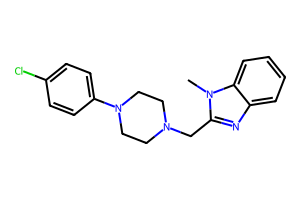

In [8]:
output_dir = 'assets/images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generate the molecule image
molecule = Draw.MolsToGridImage([Chem.MolFromSmiles(sm)],
                molsPerRow=1, subImgSize=(300,200), returnPNG=False)
molecule.save(os.path.join(output_dir, 'first_molecule.png'))
molecule

<div style="text-align:left;color:Maroon">
    <h4>Let's build a dataframe with some important attributes for each of the first 12 molecules. Twelve because it makes grid plotting easier. Here, we convert a tensor (the target, data.y) to an array for simplicity.</h4>
</div>

In [9]:
top_n = 12
data_attrib = []

for data in dataset[:top_n]:
    data_attrib.append([data.num_nodes, data.num_edges, data.smiles, np.array(data.y[0])[0]])

data_attr = pd.DataFrame(data_attrib)
data_attr.columns = ['num_nodes', 'num_edges', 'smiles', 'target_logD']
data_attr.head(top_n)

,num_nodes,num_edges,smiles,target_logD
0,24,54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54
1,33,70,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18
2,21,46,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69
3,28,62,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37
4,28,58,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10
5,23,52,OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4,3.14
6,35,74,COc1cc(OC)c(cc1NC(=O)CCC(=O)O)S(=O)(=O)NCc2ccc...,-0.72
7,34,72,CNc1cccc(CCOc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...,0.34
8,23,50,COc1ccc(cc1)C2=COc3cc(OC)cc(OC)c3C2=O,3.05
9,15,34,Oc1ncnc2scc(c3ccsc3)c12,2.25


<div style="text-align:left;color:Maroon">
    <h4>Next, we plot the molecular structure for the first 12 molecules. We use the package 'pubchempy' to convert smiles into chemical names. Then we shorten the names for visual clarity (in subplot titles and the above dataframe). To do so, we split the name and use the last string piece after the last ')' or ']', whichever is the shortest.</h4>
</div>

In [10]:
ch_names = []
for i in data_attr["smiles"]:
    compounds = pubchempy.get_compounds(i, namespace='smiles')
    match = compounds[0]
    names = [match.iupac_name.split(')')[-1], match.iupac_name.split(']')[-1]]
    res = min(names, key=len)
    ch_names.append(res)
chem_names = ['... ' + str(i) for i in ch_names]
data_attr["name"] = chem_names
data_attr

,num_nodes,num_edges,smiles,target_logD,name
0,24,54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54,... -1-methylbenzimidazole
1,33,70,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18,... sulfanylacetic acid
2,21,46,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69,... acetate
3,28,62,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37,... pyrrole-5-carboxamide
4,28,58,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10,... -2-methylpyrazole-3-carboxamide
5,23,52,OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4,3.14,... octan-3-ol
6,35,74,COc1cc(OC)c(cc1NC(=O)CCC(=O)O)S(=O)(=O)NCc2ccc...,-0.72,... -4-oxobutanoic acid
7,34,72,CNc1cccc(CCOc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...,0.34,... propanoic acid
8,23,50,COc1ccc(cc1)C2=COc3cc(OC)cc(OC)c3C2=O,3.05,... chromen-4-one
9,15,34,Oc1ncnc2scc(c3ccsc3)c12,2.25,... pyrimidin-4-one


<div style="text-align:left;color:Maroon">
    <h4>Save the dataframe as an image using a great python package called 'dataframe_image'</h4>
</div>

In [11]:
df_styled =  data_attr.style.background_gradient()
dfi.export(df_styled, "assets/images/data_attrib.png")

<div style="text-align:left;color:Maroon">
    <h4>We are now ready to plot the 12 molecules</h4>
</div>

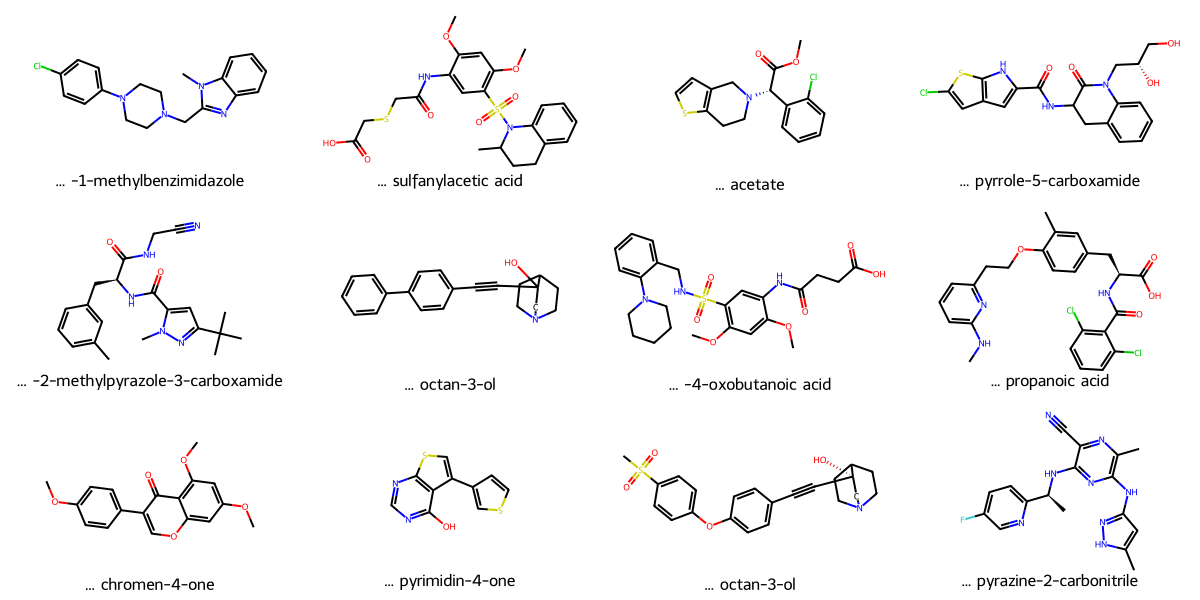

In [12]:
img = Draw.MolsToGridImage([Chem.MolFromSmiles(data_attr["smiles"][i]) for i in range(top_n)],
                         molsPerRow=4,subImgSize=(300,200), legends=list(data_attr.name.values),
                         returnPNG=False)
img.save('assets/images/molecules.png')
img

<div style="text-align:left;color:Maroon">
    <h4>To visualize two of the graphs (the first and tenth graph from our original dataset), we convert PyTorch Geometric graph to to NetworkX. Note that there are 24 nodes in the first graph and 27 in the second.</h4>
</div>

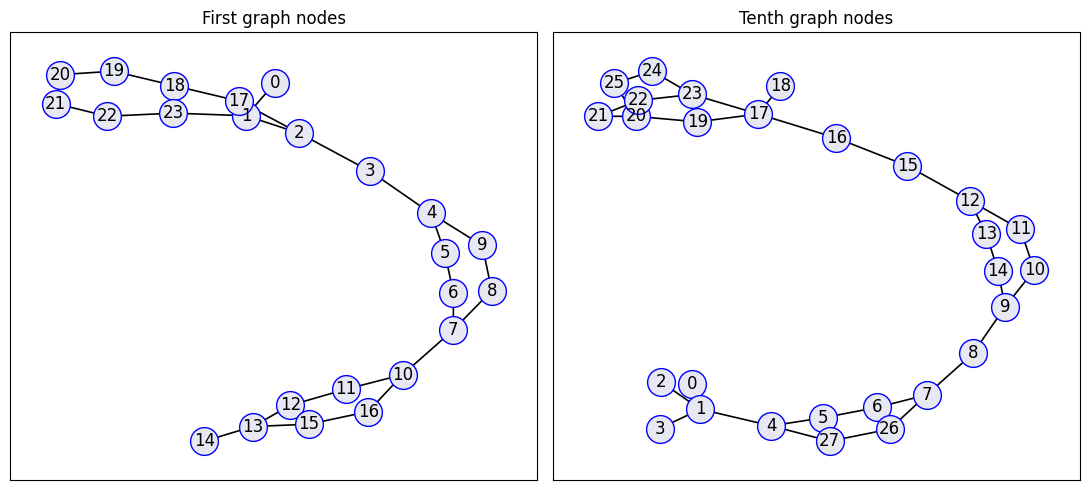

In [13]:
def visualize_net():
    plt.figure(figsize=(11,5))
    ax1 = plt.subplot2grid(shape=(1, 2), loc=(0,0))
    ax2 = plt.subplot2grid(shape=(1, 2), loc=(0,1))
    ax1.set_title('First graph nodes')
    ax2.set_title('Tenth graph nodes')

    G = to_networkx(dataset[0], to_undirected=True)

    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=14), with_labels=True,
                     node_color=[0.91, 0.91, 0.95], node_size=400, width=1.2,
                     edgecolors='blue', cmap="Set2", ax=ax1)

    G = to_networkx(dataset[10], to_undirected=True)
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=14), with_labels=True,
                    node_color=[0.91, 0.91, 0.95], node_size=400, width=1.2,
                    edgecolors='blue', cmap="Set2", ax=ax2)
    plt.tight_layout()
    plt.savefig('assets/images/graphs.png', bbox_inches='tight')
    plt.show()

visualize_net()

<div style="text-align:center;color:Blue">
    <h3> Solubility regression with GNN</h3>
</div>

#### Steps:
1. Create a GCN model structure that contains three GCNConv layers, and 64 hidden channels.  

2. Perform graph level (one y-value per graph) prediction

In [14]:
# Constants
embedding_size = 64
NUM_GRAPHS_PER_BATCH = 64
NUM_EPOCHS = 2000
LEARNING_RATE = 0.0007
TRAIN_SPLIT_RATIO = 0.8

def r2_accuracy(pred_y, y):
    return round(r2_score(y, pred_y), 2) * 100

class GCN(torch.nn.Module):
    def __init__(self, num_features):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size * 2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)

        # Classifier (Linear)
        out = self.out(hidden)
        return out, hidden

model = GCN(dataset.num_features)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))


GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


<div style="text-align:center;color:Blue">
    <h3> Train the GNN</h3>
</div>

Here, we use sklearn's r2_score to measure performance to follow accuracy through time. As this is a regression problem, the right metric is RMSE, but for visual follow-up we calculate accuracy as it is the most intuitive metric. Training using 500 epochs takes about 11 minutes on a Macbook Pro with 64 GB 2667 MHz DDR4, 2.4 GHz 8-Core Intel Core i9, AMD Radeon Pro 5600M 8 GB, Intel UHD Graphics 630 1536 MB.

Automated batching multiple graphs into a single giant graph is taken care of by PyTorch Geometric's torch_geometric.data.DataLoader class.

#### Training consists of these three major steps:

1. Embed
2. Aggregate into a readout graph
3. Use a function to convert the readout into a classifier.

Depending on how long the model is trained, accuracy can reach as high as 99%, which is undesirable (overtraining). As the dataset is very small, you will notice accuracy and loss fluctuations.
<br>

In [15]:
# Use GPU for training, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def train(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss, total_acc = 0, 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)
        loss = loss_fn(pred, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += r2_accuracy(pred.detach().cpu().numpy(), batch.y.cpu().numpy())
    return total_loss / len(loader), total_acc / len(loader)

def evaluate(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)
            loss = loss_fn(pred, batch.y)
            total_loss += loss.item()
            total_acc += r2_accuracy(pred.cpu().numpy(), batch.y.cpu().numpy())
            all_preds.append(pred.cpu().numpy())
            all_targets.append(batch.y.cpu().numpy())
    return total_loss / len(loader), total_acc / len(loader), all_preds, all_targets

def plot_metrics(losses, accuracies):
    epochs = range(len(losses))
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss vs Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label='R2 Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('R2 Accuracy (%)')
    plt.legend()
    plt.title('Training Accuracy vs Epochs')

    plt.tight_layout()
    plt.show()

# Data Preparation
data_size = len(dataset)
dataset = dataset.shuffle()
train_dataset = dataset[:int(data_size * TRAIN_SPLIT_RATIO)]
test_dataset = dataset[int(data_size * TRAIN_SPLIT_RATIO):]

train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

print('\n======== data distribution =======\n')
print(f"Size of training data: {len(train_dataset)} graphs")
print(f"Size of testing data: {len(test_dataset)} graphs")

# Model Initialization
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GCN(dataset.num_features).to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training Loop
train_losses, train_accuracies = [], []
print('\n======== Starting training ... =======\n')
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    if epoch % 100 == 0 or epoch == NUM_EPOCHS - 1:
        print(f"Epoch {epoch:>3} | Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")

print("\nTraining done!\n")
elapsed = time.time() - start_time
minutes_e = elapsed//60
print("--- training took:  %s minutes ---" % (minutes_e))

# ========================================================================================================================


======== data distribution =======

Size of training data: 3360 graphs
Size of testing data: 840 graphs

======== Starting training ... =======

Epoch   0 | Train Loss: 1.78113 | Train Acc: -29.43%
Epoch 100 | Train Loss: 0.73465 | Train Acc: 47.09%
Epoch 200 | Train Loss: 0.45296 | Train Acc: 67.28%
Epoch 300 | Train Loss: 0.30072 | Train Acc: 78.30%
Epoch 400 | Train Loss: 0.25057 | Train Acc: 81.68%
Epoch 500 | Train Loss: 0.18947 | Train Acc: 85.96%
Epoch 600 | Train Loss: 0.16796 | Train Acc: 87.75%
Epoch 700 | Train Loss: 0.12780 | Train Acc: 90.66%
Epoch 800 | Train Loss: 0.10972 | Train Acc: 91.98%
Epoch 900 | Train Loss: 0.09267 | Train Acc: 93.23%
Epoch 1000 | Train Loss: 0.08516 | Train Acc: 93.75%
Epoch 1100 | Train Loss: 0.06317 | Train Acc: 95.42%
Epoch 1200 | Train Loss: 0.05557 | Train Acc: 95.96%
Epoch 1300 | Train Loss: 0.05327 | Train Acc: 96.19%
Epoch 1400 | Train Loss: 0.04560 | Train Acc: 96.66%
Epoch 1500 | Train Loss: 0.04027 | Train Acc: 97.06%
Epoch 1600 | Tr

In [17]:
# Evaluation
test_loss, test_acc, test_preds, test_targets = evaluate(model, test_loader, loss_fn, device)
print(f"\nTest Loss: {test_loss:.5f} | Test R2 Accuracy: {test_acc:.2f}%")

elapsed_time = time.time() - start_time
print(f"Total training time: {elapsed_time // 60:.0f} min {elapsed_time % 60:.0f} sec")



Test Loss: 0.73666 | Test R2 Accuracy: 50.29%
Total training time: 21 min 7 sec


<div style="text-align:left;color:Maroon">
    <h4>Explore training results, visually!</h4>
</div>

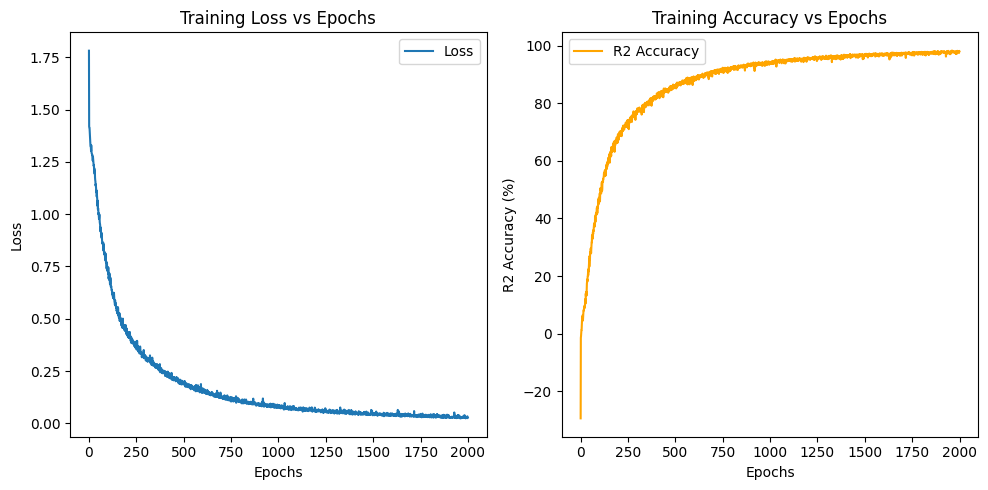

Final Test RMSE: 0.88335 | Final Test MAE: 0.63938


In [19]:
# Metrics Visualization
plot_metrics(train_losses, train_accuracies)

# Further Metrics Calculation (Optional)
final_preds = torch.cat([torch.tensor(p) for p in test_preds]).view(-1)
final_targets = torch.cat([torch.tensor(t) for t in test_targets]).view(-1)
rmse = np.sqrt(mean_squared_error(final_targets, final_preds)) # calculate RMSE manually
mae = mean_absolute_error(final_targets, final_preds)
print(f"Final Test RMSE: {rmse:.5f} | Final Test MAE: {mae:.5f}")

<div style="text-align:left;color:Maroon">
    <h4>More performance metrics.</h4>
</div>

<div style="text-align:left;color:Maroon">
    <h5>Plot RMSE (loss) and accuracy.</h5>
</div>


<div style="text-align:center;color:Blue">
    <h3> Evaluate model: use test data</h3>
</div>

#### Now that the model is fully trained, a test data prediction can be performed to probe accuracy.
##### A few plots are shown below to help training and testing accuracy progression

In [24]:
import pandas as pd

# One batch prediction
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["real"] = df["y"].apply(lambda row: row[0])
df["pred"] = df["y_pred"].apply(lambda row: row[0])
df.head()

,y,y_pred,real,pred
0,[1.7699999809265137],[2.045408248901367],1.77,2.045408
1,[2.5],[2.41845965385437],2.50,2.418460
2,[3.299999952316284],[3.312263250350952],3.30,3.312263
3,[2.7300000190734863],[2.3118627071380615],2.73,2.311863
4,[1.2999999523162842],[2.5301971435546875],1.30,2.530197


In [25]:
test_acc = r2_accuracy(df["real"], df["pred"])
test_acc_1st_20 = r2_accuracy(df["real"][:20], df["pred"][:20])

print("Test accuracy is {}%".format(round(test_acc, 2) ))
print("1st 20 test accuracy is {}%".format(round(test_acc_1st_20, 2)))

Test accuracy is 38.0%
1st 20 test accuracy is 76.0%



### Note the low test accuracy value, which as mentioned before, could be due to over training (the last 20 samples during training were predicted at 76% accuracy).
Perhaps, if we try larger data for testing, smaller data and epochs for training then the test accuracy may improve.
